In [1]:
%matplotlib inline
DEFAULT_FIGSIZE = (16, 12)

import gzip
import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

import scipy.stats

sys.path.append('..')
from antlia import dtc
from antlia import exp2
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia.plotdf import plotjoint

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

In [2]:
braking_df = pd.read_pickle('trial2_braking_ttc.p.gz')

# remove rows associated with rider 15
braking_df = braking_df.drop(
    braking_df[braking_df['rider id'] == 15].index)

# rename rider 16 to 15
braking_df.loc[braking_df['rider id'] == 16, 'rider id'] = 15
braking_df = braking_df.reset_index(drop=True)

In [3]:
steering_df = pd.read_pickle('trial2_steering_ttc.p.gz')

# rider 16 already dropped

In [4]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'float_format', '{:0.3f}'.format):
    print('braking dataframe')
    display(braking_df)
    print('steering dataframe')
    display(steering_df)

braking dataframe


,linregress slope,linregress intercept,linregress r-value,linregress p-value,linregress stderr,starting velocity,braking duration,braking distance,braking starttime,braking endtime,window size,lockup ranges,rider id,trial id,distance-to-collision,time-to-collision,braking x-position start,braking x-position end,braking x-displacement
0,-0.698,92.942,-0.967,0.000,0.008,3.694,4.401,8.091,128.370,132.770,55,0,0,0,7.815,2.115,6.285,-1.816,8.101
1,-1.471,855.737,-0.997,0.000,0.006,4.713,3.296,8.010,578.273,581.570,55,0,0,1,8.705,1.847,7.185,-0.808,7.993
2,-1.900,1257.373,-0.997,0.000,0.008,5.581,3.168,9.640,658.551,661.720,55,0,0,2,10.068,1.804,8.530,-1.133,9.664
3,-1.717,1756.369,-0.994,0.000,0.010,4.524,2.864,7.395,1020.226,1023.090,55,0,0,6,7.788,1.722,6.292,-1.125,7.417
4,-1.759,1944.489,-0.994,0.000,0.012,3.082,2.088,3.388,1103.388,1105.477,55,0,0,7,4.187,1.359,2.675,-0.728,3.402
5,-2.140,2523.997,-0.996,0.000,0.009,5.799,3.072,9.353,1176.298,1179.370,55,0,0,8,9.950,1.716,8.437,-0.941,9.378
6,-1.962,2990.284,-0.995,0.000,0.010,5.965,3.428,11.289,1520.923,1524.351,55,1,0,12,11.586,1.942,10.083,-0.977,11.060
7,-1.589,2607.772,-0.995,0.000,0.011,2.877,1.656,2.942,1639.394,1641.050,55,0,0,13,3.300,1.147,1.817,-1.141,2.959
8,-2.171,3731.208,-0.993,0.000,0.015,4.665,2.584,6.200,1716.346,1718.931,55,0,0,14,6.976,1.496,5.480,-0.741,6.221
9,-0.799,422.680,-0.997,0.000,0.002,4.415,5.841,11.928,523.390,529.230,55,0,1,3,13.000,2.944,11.252,-0.692,11.944


steering dataframe


,index start,index apex,index end,index minimum clearance,event duration,minimum y,gaussianfit amplitude,gaussianfit mean,gaussianfit std,gaussianfit offset,gaussianfit nrmsd,starting velocity,distance-to-collision,time-to-collision,lateral clearance,minimum clearance,rider id,trial id,steering x-position start,steering x-position end,steering x-displacement
0,585,918,1165,870,4.641,2.216,-0.918,-4.837,3.064,3.133,0.003,3.496,5.681,1.625,0.844,0.771,0,3,4.157,-11.868,16.024
1,315,554,763,528,3.584,2.103,-1.040,-5.092,4.313,3.146,0.009,5.937,7.847,1.322,0.957,0.918,0,4,6.282,-15.181,21.464
2,377,657,887,657,4.081,2.154,-0.965,-3.647,3.903,3.117,0.002,4.667,8.286,1.776,0.906,0.906,0,5,6.723,-12.486,19.208
3,364,673,880,672,4.129,2.197,-0.882,-3.431,3.785,3.072,0.006,4.691,9.250,1.972,0.863,0.863,0,9,7.686,-11.551,19.237
4,174,447,650,440,3.808,2.201,-0.875,-3.971,4.599,3.074,0.002,6.132,10.880,1.774,0.859,0.857,0,10,9.245,-14.422,23.666
5,413,795,1100,821,5.497,2.060,-1.096,-3.150,3.109,3.158,0.004,3.389,8.745,2.581,1.000,0.977,0,11,7.214,-11.653,18.867
6,268,503,728,504,3.684,2.176,-0.969,-3.878,4.506,3.145,0.004,6.055,8.955,1.479,0.884,0.884,0,15,7.416,-14.842,22.258
7,195,664,944,648,5.993,2.132,-0.931,-3.977,4.370,3.067,0.007,4.666,14.768,3.165,0.928,0.920,0,16,13.133,-14.866,27.999
8,398,882,1180,879,6.257,2.123,-1.113,-3.623,3.491,3.236,0.008,3.348,10.982,3.281,0.937,0.937,0,17,9.446,-11.980,21.426
9,734,941,1127,971,3.144,2.082,-1.237,-2.979,2.938,3.295,0.011,3.228,3.683,1.141,0.978,0.946,1,0,2.156,-7.910,10.065


In [5]:
def df_speed_subset(dataframe, speed):
    index = []
    for (i, j) in dataframe[['rider id', 'trial id']].values:
        if i == 15:
            i = 16
        index.append(speed == exp2.instructed_speed(i, j))
    return dataframe[index]

#df_speed_subset(steering_df, 12/3.6)

for name, df_type in zip(['braking', 'steering'], [braking_df, steering_df]):
    for speed in [None, 12, 17, 22]:
        if speed is None:
            df = df_type
            speed_str = ''
        else:
            df = df_speed_subset(df_type, speed/3.6)
            speed_str = str(speed)
            
        for xtc in ['time-to-collision', 'distance-to-collision']:
            xtc_short = xtc[0] + 'tc'
            print('{} {}{} {:0.2f}±{:0.2f}'.format(
                name, xtc_short, speed_str, df[xtc].mean(), df[xtc].std()))
            

braking ttc 2.16±0.82
braking dtc 9.65±4.66
braking ttc12 2.01±0.81
braking dtc12 6.45±2.76
braking ttc17 2.17±0.86
braking dtc17 9.57±3.90
braking ttc22 2.30±0.78
braking dtc22 12.87±4.69
steering ttc 2.12±0.85
steering dtc 9.51±3.64
steering ttc12 2.52±0.96
steering dtc12 8.52±3.40
steering ttc17 2.08±0.83
steering dtc17 9.73±3.98
steering ttc22 1.75±0.55
steering dtc22 10.31±3.34


In [6]:
fields = [
    ('braking duration', 'duration'),
    ('braking x-displacement', 'longitudinal distance'),
    ('linregress slope', 'deceleration'),
]

for type_name, df_type in zip(['braking'], [braking_df]):
    for speed in [None, 12, 17, 22]:
        if speed is None:
            df = df_type
            speed_str = ''
        else:
            df = df_speed_subset(df_type, speed/3.6)
            speed_str = str(speed)
            
        for label, field_name in fields:
            print('{} \'{}\' {} {:0.2f}±{:0.2f}'.format(
                type_name, field_name, speed_str, df[label].mean(), df[label].std()))

braking 'duration'  3.57±1.45
braking 'longitudinal distance'  8.35±4.44
braking 'deceleration'  -1.53±0.63
braking 'duration' 12 3.13±1.38
braking 'longitudinal distance' 12 5.31±2.54
braking 'deceleration' 12 -1.31±0.59
braking 'duration' 17 3.64±1.52
braking 'longitudinal distance' 17 8.32±3.73
braking 'deceleration' 17 -1.56±0.64
braking 'duration' 22 3.92±1.36
braking 'longitudinal distance' 22 11.37±4.57
braking 'deceleration' 22 -1.73±0.60


In [7]:
fields = [
    ('event duration', 'duration'),
    ('steering x-displacement', 'longitudinal distance'),
    ('minimum clearance', 'clearance'),
]

for type_name, df_type in zip(['steering'], [steering_df]):
    for speed in [None, 12, 17, 22]:
        if speed is None:
            df = df_type
            speed_str = ''
        else:
            df = df_speed_subset(df_type, speed/3.6)
            speed_str = str(speed)
            
        for label, field_name in fields:
            print('{} \'{}\' {} {:0.2f}±{:0.2f}'.format(
                type_name, field_name, speed_str, df[label].mean(), df[label].std()))

steering 'duration'  4.63±1.20
steering 'longitudinal distance'  20.17±4.46
steering 'clearance'  1.12±0.16
steering 'duration' 12 5.48±1.19
steering 'longitudinal distance' 12 18.14±3.96
steering 'clearance' 12 1.10±0.16
steering 'duration' 17 4.58±1.03
steering 'longitudinal distance' 17 20.68±4.62
steering 'clearance' 17 1.11±0.15
steering 'duration' 22 3.81±0.68
steering 'longitudinal distance' 22 21.74±4.05
steering 'clearance' 22 1.13±0.15


In [8]:
print('starting velocity vs steering time-to-collision')
print(scipy.stats.linregress(steering_df[['starting velocity', 'time-to-collision']]))
print()

print('starting velocity vs braking duration')
print(scipy.stats.linregress(braking_df[['starting velocity', 'braking duration']]))
print()

print('starting velocity vs steering duration')
print(scipy.stats.linregress(steering_df[['starting velocity', 'event duration']]))
print()


starting velocity vs steering time-to-collision
LinregressResult(slope=-0.2611809926288291, intercept=3.3269232320606141, rvalue=-0.32387706507588682, pvalue=7.0706247570924031e-05, stderr=0.063801371926328024)

starting velocity vs braking duration
LinregressResult(slope=0.37622609268447688, intercept=1.9137257103703977, rvalue=0.270709019514566, pvalue=0.0010751809781585886, stderr=0.11267047039865334)

starting velocity vs steering duration
LinregressResult(slope=-0.60600705970909619, intercept=7.4344647989356414, rvalue=-0.5347265637657691, pvalue=4.271223077410167e-12, stderr=0.080084328746040878)



In [9]:
def field_rvalue_stats(df_name, field):
    if df_name == 'braking':
        dataframe = braking_df
    else:
        dataframe = steering_df
        
    df = dataframe[['rider id', 'starting velocity', field]]
    rvalue = []
    for i in range(16):
        df_i = df[df['rider id'] == i].drop('rider id', axis=1)
        lr = scipy.stats.linregress(df_i)
        rvalue.append(lr.rvalue)
    rvalue = np.asarray(rvalue)
    
    float_format = '{:0.2f}'
    print('{}, {}'.format(df_name, field))
    print('rvalue min: {}'.format(float_format).format(rvalue.min()))
    print('rvalue max: {}'.format(float_format).format(rvalue.max()))
    print('rvalue mean: {}'.format(float_format).format(rvalue.mean()))
    print('rvalue median: {}'.format(float_format).format(np.median(rvalue)))
    
field_rvalue_stats('braking', 'distance-to-collision')
print()
field_rvalue_stats('braking', 'time-to-collision')
print()
field_rvalue_stats('steering', 'distance-to-collision')
print()
field_rvalue_stats('steering', 'time-to-collision')
print()
field_rvalue_stats('steering', 'lateral clearance')
print()
field_rvalue_stats('steering', 'minimum clearance')
print()
field_rvalue_stats('steering', 'steering x-displacement')

braking, distance-to-collision
rvalue min: 0.61
rvalue max: 0.97
rvalue mean: 0.86
rvalue median: 0.93

braking, time-to-collision
rvalue min: -0.68
rvalue max: 0.93
rvalue mean: 0.32
rvalue median: 0.47

steering, distance-to-collision
rvalue min: -0.22
rvalue max: 0.76
rvalue mean: 0.32
rvalue median: 0.33

steering, time-to-collision
rvalue min: -0.73
rvalue max: -0.09
rvalue mean: -0.48
rvalue median: -0.53

steering, lateral clearance
rvalue min: -0.62
rvalue max: 0.89
rvalue mean: 0.25
rvalue median: 0.40

steering, minimum clearance
rvalue min: -0.66
rvalue max: 0.83
rvalue mean: 0.16
rvalue median: 0.23

steering, steering x-displacement
rvalue min: -0.55
rvalue max: 0.94
rvalue mean: 0.43
rvalue median: 0.52


'#464646'

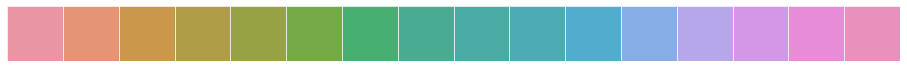

In [4]:
# categorical plots use a default saturation of 0.75
CATEGORICAL_PLOT_SATURATION = 0.75
helper = sns.categorical._CategoricalPlotter()
helper.hue_names = list(range(16))
helper.establish_colors(color=None, palette=None,
                        saturation=CATEGORICAL_PLOT_SATURATION)
sns.palplot(helper.colors)
helper.gray

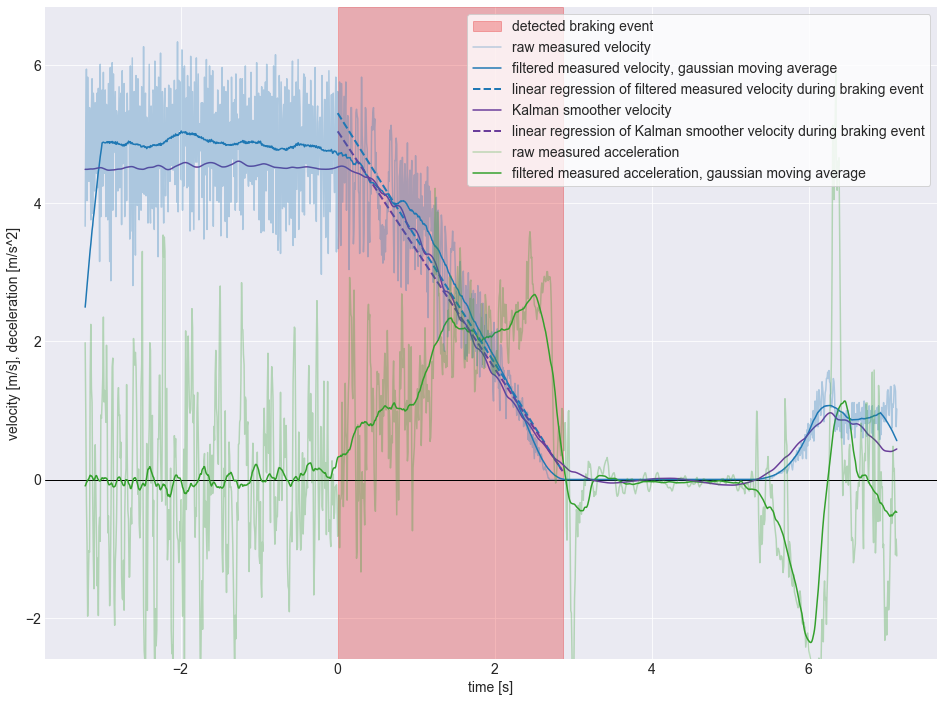

In [5]:
from antlia import exp2

try:
    r0
except NameError:
    with gzip.open('exp2record00.p.gz', 'rb') as f:
        r0 = pickle.load(f)

# Create braking plot for trial 0-6
plt.close('all')
mpl.rcParams.update({'font.size': 14})
mpl.rcParams.update({'svg.fonttype': 'none'})

fig, ax = braking.plot_trial_braking_event(
    r0.trials[6].event,
    metrics_kw=exp2.METRICS_KW,
    use_kalman=True,
    figsize=DEFAULT_FIGSIZE)

# recreate legend
# ignore last line as it is the x-axis
lines = ax.lines[:-1]
# using known order for this example
handles = [
    'filtered measured velocity, gaussian moving average',
    'filtered measured acceleration, gaussian moving average',
    'linear regression of filtered measured velocity during braking event',
    'Kalman smoother velocity',
    'linear regression of Kalman smoother velocity during braking event',
    'raw measured velocity',
    'raw measured acceleration',
]

# get handle for vspan (only 1)
lines.extend(ax.patches)
handles.append('detected braking event')

# update time t=0 to be at braking onset by
# modifying the data in the lines and patches
t_offset = braking_df[
                (braking_df['rider id'] == 0) &
                (braking_df['trial id'] == 6)
           ]['braking starttime'].values[0]
for l in ax.lines[:-1]:
    # skip x-axis line
    l.set_xdata(l.get_xdata() - t_offset)
for p in ax.patches:
    p.set_xy(p.get_xy() - [t_offset, 0])

# update limits and view after modifying artist data
ax.relim()
ax.autoscale()
ax.set_ylim(-2.6, None)

# update legend
legend_order = [7, 5, 0, 2, 3, 4, 6, 1]
ax.legend(np.asarray(lines)[legend_order],
          np.asarray(handles)[legend_order],
          loc='upper right')

# update title and label
ax.set_ylabel('velocity [m/s], deceleration [m/s^2]')
ax.set_title('')

fig.savefig('fig1.svg')
fig.savefig('fig1.eps')
plt.show()

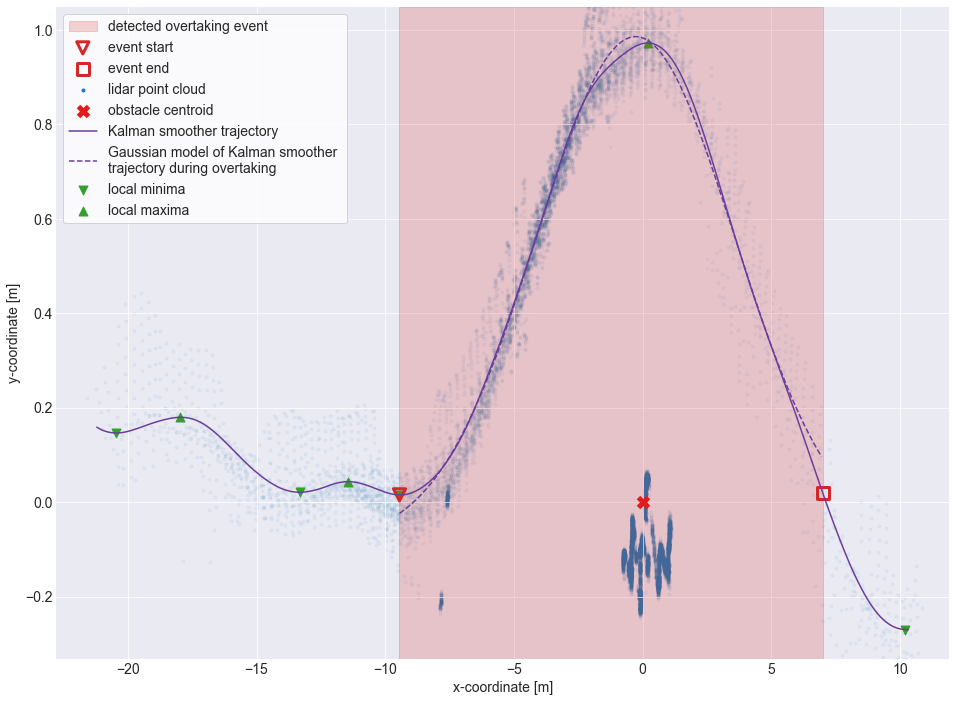

In [6]:
from antlia import trial2
from copy import copy

mpl.rcParams.update({'font.size': 14})
mpl.rcParams.update({'svg.fonttype': 'none'})

try:
    r11
except NameError:
    with gzip.open('exp2record11.p.gz', 'rb') as f:
        r11 = pickle.load(f)
j = 7
event = r11.trials[j].event

colors = sns.color_palette('Paired', 10)
    
plt.close('all')

fig, ax = plt.subplots()
# modify the markers as the figure will be rotated
region = trial2.find_steering_region(event,
                                     ax=ax,
                                     obstacle_origin=True,
                                     markers=['v', '^', 'v', 's'])
ax.lines[0].set_color(colors[9])

p = ax.patches[0]
p.set_label('detected overtaking event')
p.set_hatch('')
p.set_fill(True)
p.set_alpha(0.2)

c0 = ax.collections[0]
c0.set_label('detected trajectory local y-maxima')
c0.set_color(colors[3])

c1 = ax.collections[1]
c1.set_label('detected trajectory local y-minima')
c1.set_color(colors[3])

plot_kw = {
    'label': 'Gaussian model of Kalman smoother \ntrajectory during overtaking',
    'color': colors[9],
    'linestyle': '--',
    #'linewidth': 3
}
params = trial2.fit_steering_model(event,
                                   region,
                                   ax=ax,
                                   obstacle_origin=True,
                                   **plot_kw)

ax.scatter(event.x - trial2.OBSTACLE_POINT[0],
           event.y - trial2.OBSTACLE_POINT[1],
           label='lidar point cloud',
           marker='.',
           color=colors[1],
           alpha=0.05,
           zorder=-1)

ax.scatter(
    0,
    0,
    s=100,
    marker='x',
    linewidth=5,
    color=colors[5],
    label='obstacle centroid'
)


# rotate image 180 deg by inverting x and y data,
# modifying the data in the lines, patches, and collections
for l in ax.lines:
    l.set_xdata(-l.get_xdata())
    l.set_ydata(-l.get_ydata())
for p in ax.patches:
    p.set_xy(np.multiply(p.get_xy(), [-1, 1]))
for c in ax.collections:
    c.set_offsets(-1*c.get_offsets())

# update limits and view after modifying artist data
ax.relim()
ax.autoscale()

# re-define legend entries and re-order
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'Kalman smoother trajectory'

# minima and maxima need to be swapped since the figure has been rotated
# the markers are stored as paths so we need to invert the y-axis
labels[3] = 'local minima'
labels[4] = 'local maxima'

# decrease alpha for lidar point cloud so it is more visible
# the collection is copied to create a proxy
def get_handle_color(h):
    return h.get_facecolor()[0][:3]
proxy_pointcloud = ax.scatter([], [],
                              marker='.',
                              color=get_handle_color(handles[7]))
handles[7] = proxy_pointcloud

label_order = [2, 5, 6, 7, 8, 0, 1, 3, 4]
ax.legend(np.asarray(handles)[label_order],
          np.asarray(labels)[label_order])

ax.set_xlabel('x-coordinate [m]')
ax.set_ylabel('y-coordinate [m]')

fig.savefig('fig2.svg')
fig.savefig('fig2.eps')
plt.show()

In [6]:
def boxswarmplot(x, y, data, ax):
    # Don't plot outliers in boxplot as they will show up in the swarmplot.
    sns.boxplot(x=x, y=y, data=data,
                ax=ax, showfliers=False)
    
    # Set alpha transparency of the boxes (excluding edges).
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.2))
    
    # Plot swarmplot in front of box face but behind median and IQR lines.
    # zorder for box is 0.9 while others are 2 or 2.1.
    sns.swarmplot(x=x, y=y, data=data,
                  ax=ax, zorder=1, alpha=1)

(numpy.record, [('slope', '<f8'), ('intercept', '<f8'), ('rvalue', '<f8'), ('pvalue', '<f8'), ('stderr', '<f8')])
pcc median:  0.931432935293
pcc range:  0.366201160204
Pearson correlation coefficient table


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
slope,2.246774,1.531933,2.389854,4.103385,2.299145,4.473979,2.172291,4.490928,1.156980,4.792374,2.303861,2.514621,1.560870,1.777634,1.324952,3.643813
intercept,-2.390966,2.161814,-3.662683,-4.935937,-4.065891,-11.048589,0.426769,-3.530376,5.338575,-9.716519,-1.293544,2.774654,-0.517199,-2.213206,0.913343,-2.536004
rvalue,0.941819,0.685747,0.828221,0.952290,0.972079,0.938188,0.853133,0.932628,0.694939,0.973025,0.716317,0.606823,0.930237,0.936753,0.790619,0.945785
pvalue,0.000148,0.041430,0.005822,0.000075,0.000012,0.000563,0.003452,0.000245,0.037718,0.000010,0.029936,0.083141,0.000276,0.000197,0.011193,0.000116
stderr,0.303066,0.614558,0.611188,0.497053,0.209771,0.673851,0.502075,0.656736,0.452481,0.429465,0.848239,1.244913,0.232724,0.251029,0.387842,0.472955


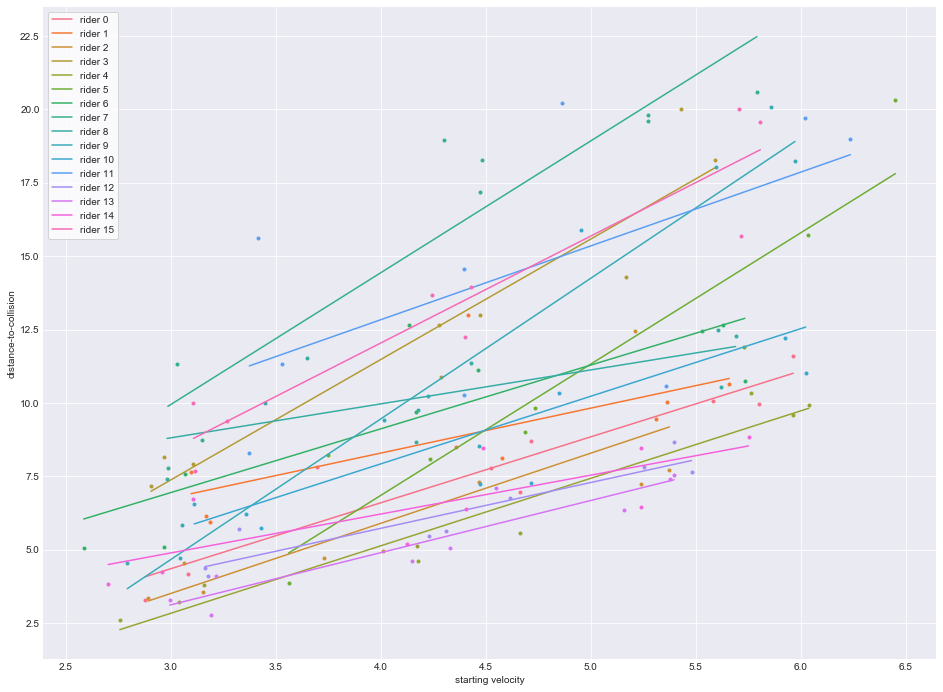

Text(0.5,0,'rider id')

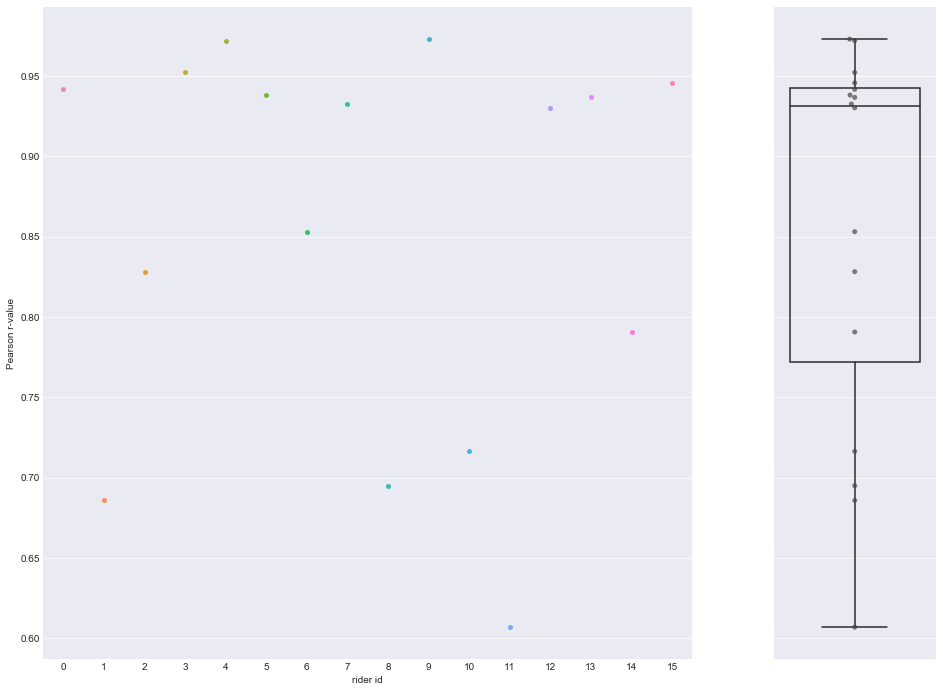

In [7]:
# results 1.1 - increase in speed results in larger braking distance
#
# Calculate pearson correlation coefficient for each person for distance-to-collision and starting velocity
# Range, median of PCC.

# How should we show this?
# Maybe we should calculate the linear regression, and then the error from the linear regression for each trial?

import scipy.stats

# Calculate Pearson correlation coefficient for each rider
pcc = []
x = []
y = []
num_riders = 16
for i in range(num_riders):
    df = braking_df[braking_df['rider id'] == i]
    xi = df['starting velocity'].values
    yi = df['distance-to-collision'].values
    reg = scipy.stats.linregress(xi, yi)
    x.append(xi)
    y.append(yi)
    pcc.append(reg)
    
# create PCC dataframe
dtype = list(zip(pcc[0]._fields, len(pcc[0]._fields)*('float',)))
pcc = np.asarray(pcc, dtype=dtype).view(np.recarray)
print(pcc.dtype)
print('pcc median: ', np.median(pcc.rvalue))
print('pcc range: ', np.ptp(pcc.rvalue))
pcc_df = pd.DataFrame(data=pcc).transpose()
print('Pearson correlation coefficient table')
display(pcc_df)

plt.close('all')
fig, ax = plt.subplots()

# Plot velocity vs. dtc for all trials
colors = sns.color_palette('husl', num_riders)
for i in range(num_riders):
    ax.plot(x[i], y[i], color=colors[i], linestyle=' ', marker='.')
    x_sorted = np.sort(x[i])
    ax.plot(x_sorted, pcc[i].slope*x_sorted + pcc[i].intercept,
            color=colors[i], label='rider {}'.format(i))
ax.set_xlabel('starting velocity')
ax.set_ylabel('distance-to-collision')
ax.legend()
plt.show()

fig2, ax2 = plt.subplots(1, 2,
                         gridspec_kw={'width_ratios': [4, 1]},
                         sharey=True)

sns.swarmplot(x=list(range(num_riders)), y=pcc.rvalue, ax=ax2[0])

sns.boxplot(pcc.rvalue, color=helper.gray, ax=ax2[1], 
            orient='v',
            showfliers=False,
            boxprops={'facecolor': (0, 0, 0, 0)})
sns.swarmplot(x=pcc.rvalue, orient='v',
              color=helper.gray, ax=ax2[1],
              alpha=0.7)
    
ax2[0].set_ylabel('Pearson r-value')
ax2[0].set_xlabel('rider id')

# Calculate residuals for each rider

PCC residual table (per rider)


,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
linregress residual,-0.774412,-0.345737,1.904900,0.014951,-1.113502,0.506417,-0.080228,-0.687502,0.575115,0.725164,...,0.309851,1.202729,-1.148525,-0.000293,0.761983,-1.247694,0.343834,1.754792,-2.596297,0.929472
rider id,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,14.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
starting velocity,2.877462,3.081553,3.694465,4.523917,4.664880,4.713384,5.580908,5.798840,5.964732,3.097177,...,5.751383,3.108715,3.117717,3.267400,4.244716,4.400665,4.431446,5.706208,5.714244,5.807667


/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


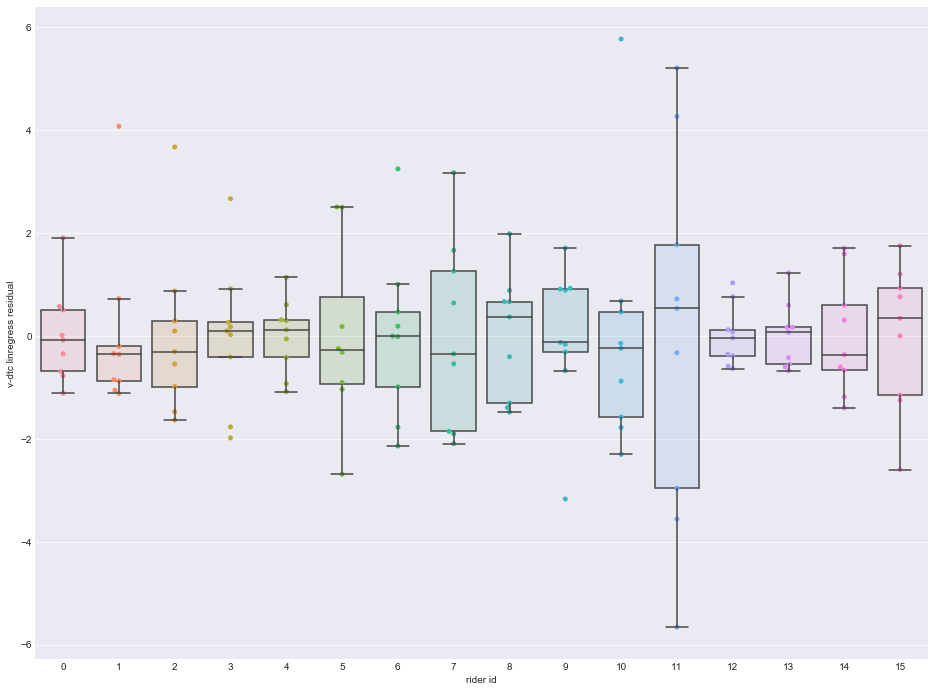

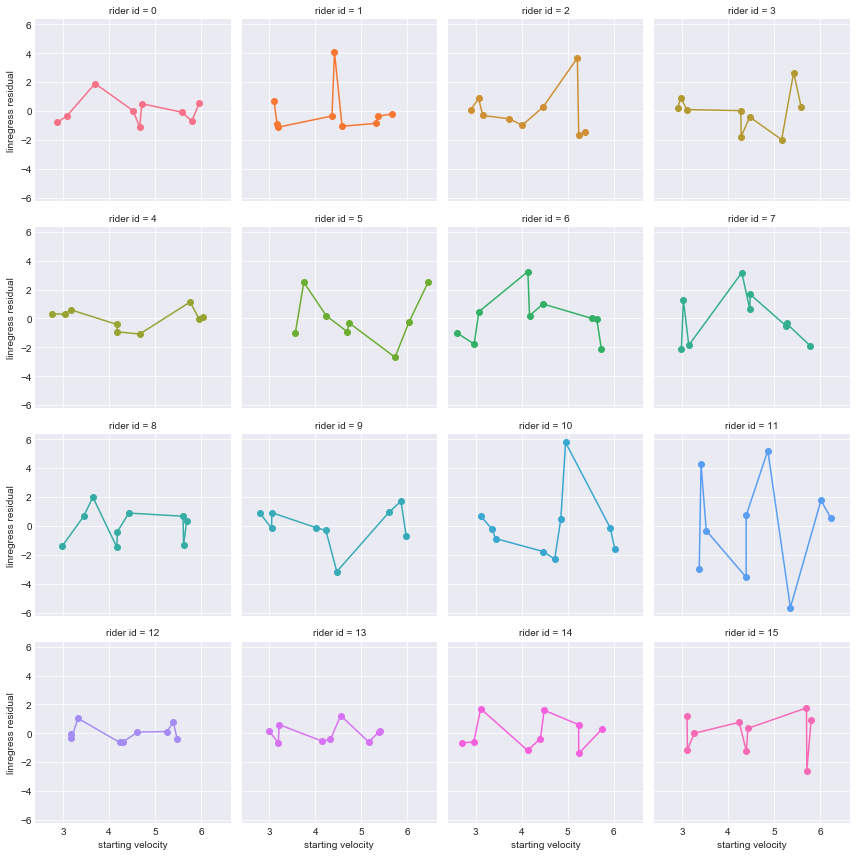

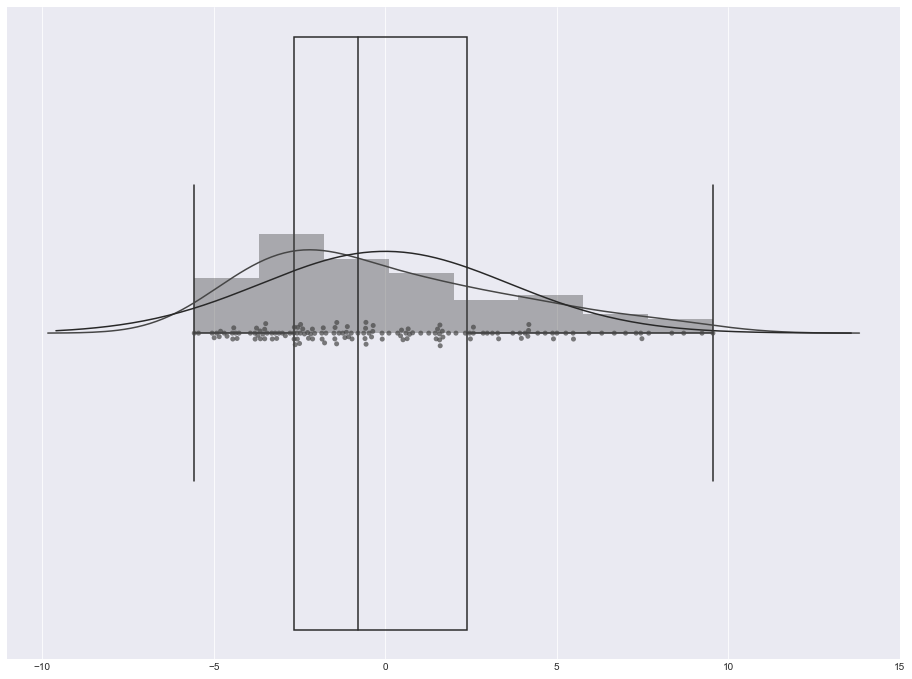

In [8]:
def calculate_linregress_residuals(data, x, y):
    x_ = data[x].values
    y_ = data[y].values
    
    reg = scipy.stats.linregress(x_, y_)
    #print(reg)
    
    sorted_index = np.argsort(x_)
    sorted_x = x_[sorted_index]
    
    observed_y = y_[sorted_index]
    predicted_y = reg.slope*sorted_x + reg.intercept
    
    residual = observed_y - predicted_y
    # print normalized residual error
    #print(np.sqrt(np.sum(residual**2))/len(residual))
    return sorted_x, residual


d = {
    'rider id': [],
    'starting velocity': [],
    'linregress residual': [],
}
for i in range(num_riders):
    sorted_velocity, residual = calculate_linregress_residuals(
        braking_df[braking_df['rider id'] == i],
        'starting velocity',
        'distance-to-collision')
    
    d['rider id'].extend(len(residual)*[i])
    d['starting velocity'].extend(sorted_velocity)
    d['linregress residual'].extend(residual)

pcc_residual_df = pd.DataFrame(data=d)
print('PCC residual table (per rider)')
display(pcc_residual_df.transpose())

fig, ax = plt.subplots()
boxswarmplot(x='rider id', y='linregress residual',
             data=pcc_residual_df,
             ax=ax)
ax.set_ylabel('v-dtc linregress residual')

# plot velocity vs. residuals for each rider
grid = sns.FacetGrid(pcc_residual_df, col='rider id', hue='rider id',
                     col_wrap=4)
grid.map(plt.plot, 'starting velocity', 'linregress residual', marker='o')

# plot boxswarm of all data
velocity_all, residual_all = calculate_linregress_residuals(
    braking_df, 'starting velocity', 'distance-to-collision')

fig, ax = plt.subplots()
sns.boxplot(residual_all,
            color=helper.gray, ax=ax, 
            #orient='v',
            showfliers=False,
            boxprops={'facecolor': (0, 0, 0, 0)})
sns.swarmplot(residual_all,
              color=helper.gray, ax=ax,
              alpha=0.7)
sns.distplot(residual_all,
             color=helper.gray, ax=ax,
             fit=scipy.stats.norm)
ax.autoscale(axis='y')

braking deceleration table


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
linregress intercept,0.789803,-0.791514,2.182335,0.548833,1.780558,1.283708,0.097014,0.136237,0.007897,1.000685,0.536691,-0.062473,1.482130,1.684636,-0.120572,0.462993
linregress pvalue,0.154345,0.010887,0.863880,0.141483,0.047104,0.857821,0.005204,0.017044,0.008089,0.622357,0.107406,0.059195,0.161449,0.134291,0.002567,0.022060
linregress rvalue,0.516715,0.792379,0.067069,0.530789,0.672670,0.076122,0.833924,0.761827,0.810292,0.191095,0.572194,0.647840,0.509233,0.538987,0.865544,0.742062
linregress slope,0.202898,0.532589,0.024180,0.066062,0.114260,0.014637,0.262710,0.130510,0.362463,0.032020,0.225520,0.256330,0.093375,0.177521,0.484909,0.102344
linregress stderr,0.127067,0.154975,0.135957,0.039868,0.047505,0.078272,0.065712,0.041944,0.099081,0.062165,0.122171,0.113923,0.059646,0.104857,0.106051,0.034943
median,1.759153,1.571708,2.338976,0.781034,2.308894,1.353796,1.102937,0.649080,1.468987,1.163118,1.459233,1.048774,1.860944,2.428944,1.954746,0.876229
std,0.421086,0.635409,0.336834,0.123319,0.205880,0.192473,0.357949,0.169813,0.426712,0.196781,0.396141,0.406121,0.162972,0.296233,0.580757,0.145598


overall
median:  1.46898666065
std:  0.627442357804


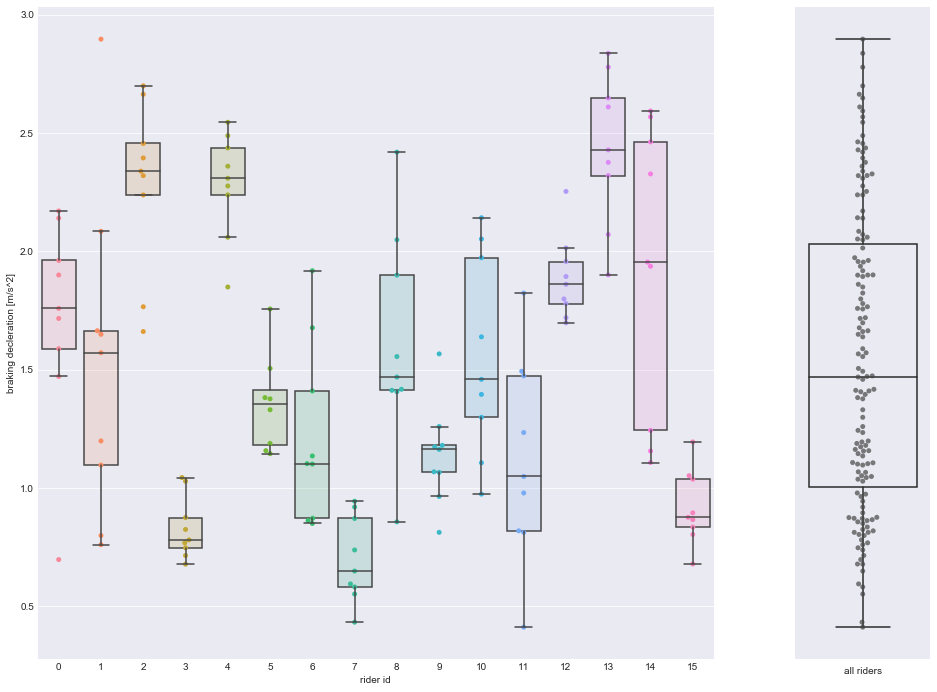

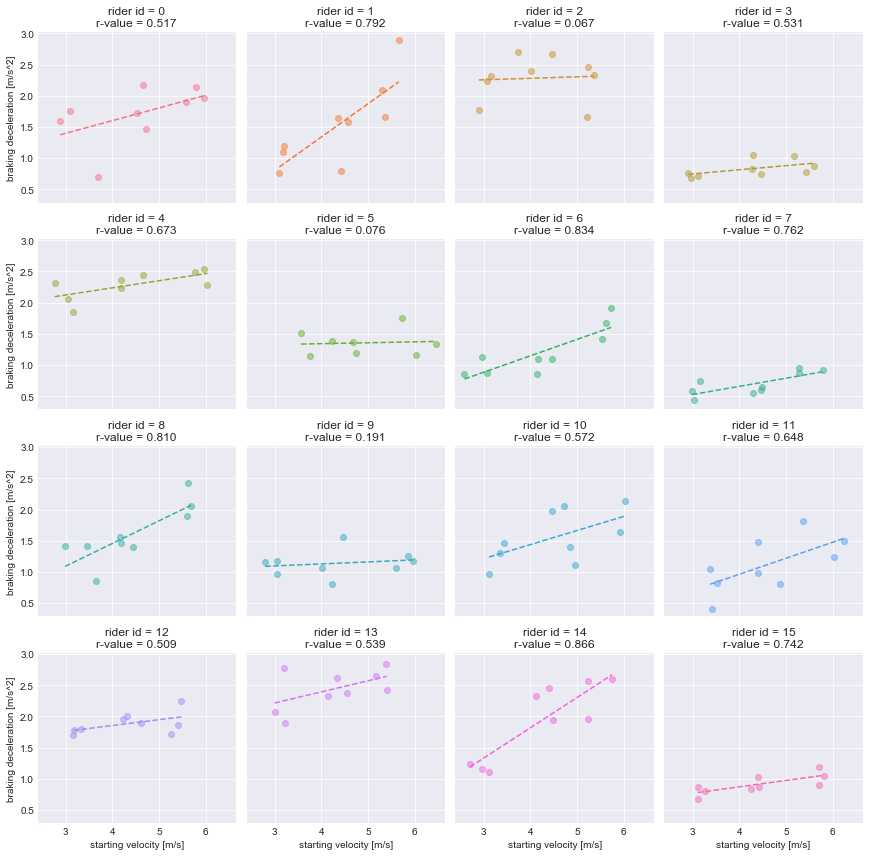

overall linear regression, onset velocity vs. deceleration constant
LinregressResult(slope=0.10234414492010678, intercept=0.46299316227889259, rvalue=0.74206210830391095, pvalue=0.022059766809449634, stderr=0.034943235571594358)


In [9]:
# results 1.2 - increase in speed results in earlier braking
#
# Braking decleration is independent from speed.

# Add deceleration column
f = lambda row: -row['linregress slope']
braking_df['deceleration'] = braking_df.apply(f, axis=1)

num_riders = 16
d = {'median': [], 'std': []}
for i in range(num_riders):
    df = braking_df[braking_df['rider id'] == i]
    v = df['deceleration'].values
    d['median'].append(np.median(v))
    d['std'].append(np.std(v))
    
    # print PCC for velocity-deceleration
    reg = scipy.stats.linregress(
        df['starting velocity'], v)
    for k in reg._fields:
        dictkey = 'linregress ' + k
        dictvalue = getattr(reg, k)
        if dictkey in d:
            d[dictkey].append(dictvalue)
        else:
            d[dictkey] = [dictvalue]
    
deceleration_df = pd.DataFrame(data=d).transpose()
print('braking deceleration table')
display(deceleration_df)

print('overall')
v = braking_df['deceleration'].values
print('median: ', np.median(v))
print('std: ', np.std(v))
    
fig, ax = plt.subplots(1, 2, sharey=True,
                       gridspec_kw={'width_ratios': [5, 1]})
                       
plot_swarm_overlay = True
                       
if not plot_swarm_overlay:
    # get a ligher gray for the box face color
    c = sns.light_palette(helper.gray)[3]
    sns.boxplot(x='deceleration', data=braking_df,
                color=helper.gray, ax=ax[1], 
                orient='v',
                boxprops={'facecolor': c})
else:
    sns.boxplot(x='deceleration', data=braking_df,
                color=helper.gray, ax=ax[1], 
                orient='v',
                showfliers=False,
                boxprops={'facecolor': (0, 0, 0, 0)})
    sns.swarmplot(y='deceleration', data=braking_df,
                  color=helper.gray, ax=ax[1],
                  alpha=0.7)
    #sns.distplot(braking_df['deceleration'].values,
    #             color=helper.gray, ax=ax[1],
    #             fit=scipy.stats.norm,
    #             vertical=True)
    #ax[1].autoscale(axis='x')

if not plot_swarm_overlay:
    sns.boxplot(x='rider id', y='deceleration',
                data=braking_df,
                ax=ax[0])
else:
    boxswarmplot(x='rider id', y='deceleration',
                 data=braking_df,
                 ax=ax[0])
ax[0].set_ylabel('braking decleration [m/s^2]')
ax[1].get_yaxis().set_visible(False)
ax[0].set_xlabel('rider id')
ax[1].set_xlabel('all riders')

# plot velocity vs. deceleration for each rider
grid = sns.FacetGrid(braking_df, col='rider id', hue='rider id',
                     col_wrap=4)

# plot deceleration for each trial
grid.map(plt.plot, 'starting velocity', 'deceleration',
         marker='o', linestyle=' ', alpha=0.5)

# plot deceleration linear regression
## we need a function that takes the 'starting velocity' dataframe column,
## sorts it, and then accesses the deceleration linear regression in order
## to plot the linefit
def sorted_plot(x, *args, **kwargs):
    i = int(kwargs['label'])
    sorted_x = np.sort(x.values)
    slope = deceleration_df[i]['linregress slope']
    intercept = deceleration_df[i]['linregress intercept']
    return plt.plot(sorted_x, slope*sorted_x + intercept, *args, **kwargs)

grid.map(sorted_plot, 'starting velocity',
         linestyle='--')

# add text with r-value to each facet
for i, axis in enumerate(grid.axes.flat):
    r = deceleration_df[i]['linregress rvalue']
    axis.set_title(axis.get_title() + '\nr-value = {:0.3f}'.format(r))
    
grid.fig.tight_layout()
grid.set_xlabels('starting velocity [m/s]')
grid.set_ylabels('braking deceleration [m/s^2]')
plt.show()

print('overall linear regression, onset velocity vs. deceleration constant')
print(scipy.stats.linregress(
    df['starting velocity'],
    df['deceleration']
))

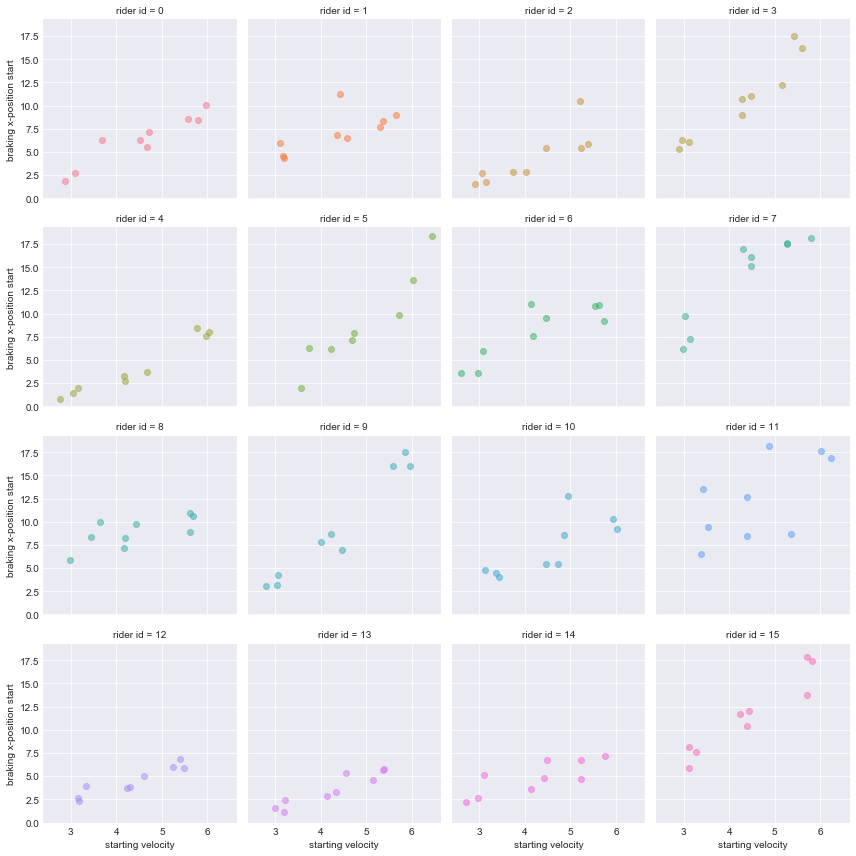

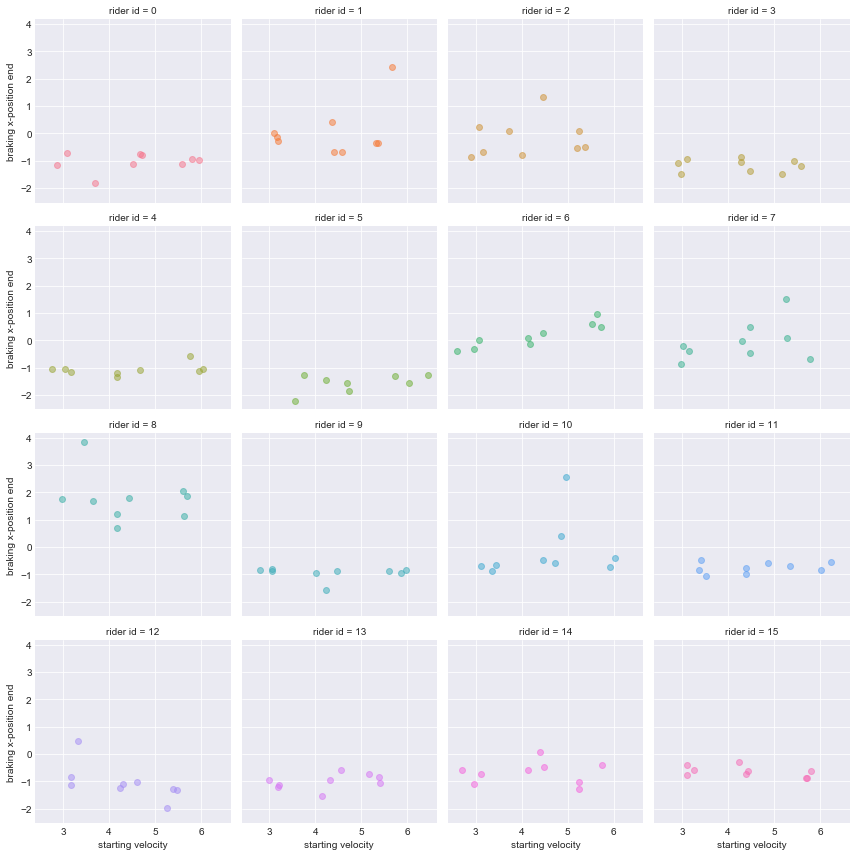

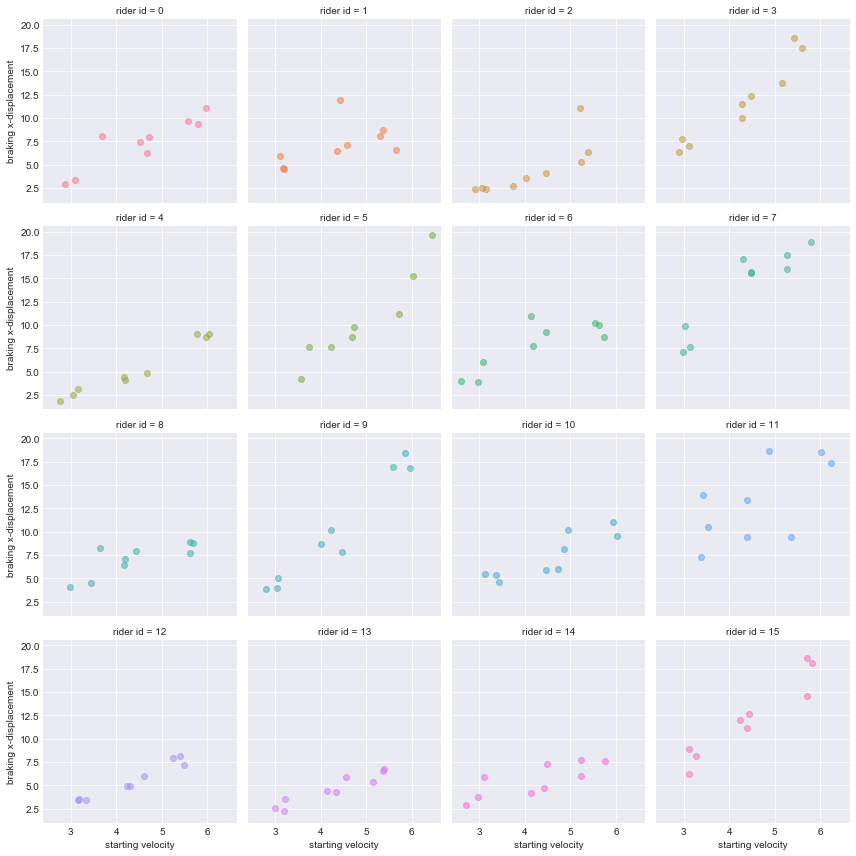

In [11]:
def plot_facet(df, x, y):
    # plot velocity vs. deceleration for each rider
    grid = sns.FacetGrid(df, col='rider id', hue='rider id',
                         col_wrap=4)
    
    # plot deceleration for each trial
    grid.map(plt.plot, x, y,
             marker='o', linestyle=' ', alpha=0.5)
    
    return grid

plot_facet(braking_df, 'starting velocity', 'braking x-position start')
plot_facet(braking_df, 'starting velocity', 'braking x-position end')
plot_facet(braking_df, 'starting velocity', 'braking x-displacement')

[ 0.69947529  1.32438832  0.46093962  0.36618947  0.48575497  0.61139516
  1.06806723  0.51127352  1.56228319  0.29560356  1.16792871  1.41189638
  0.31616197  0.93635009  1.4854216   0.51586896]


Text(0.5,0,'all riders')

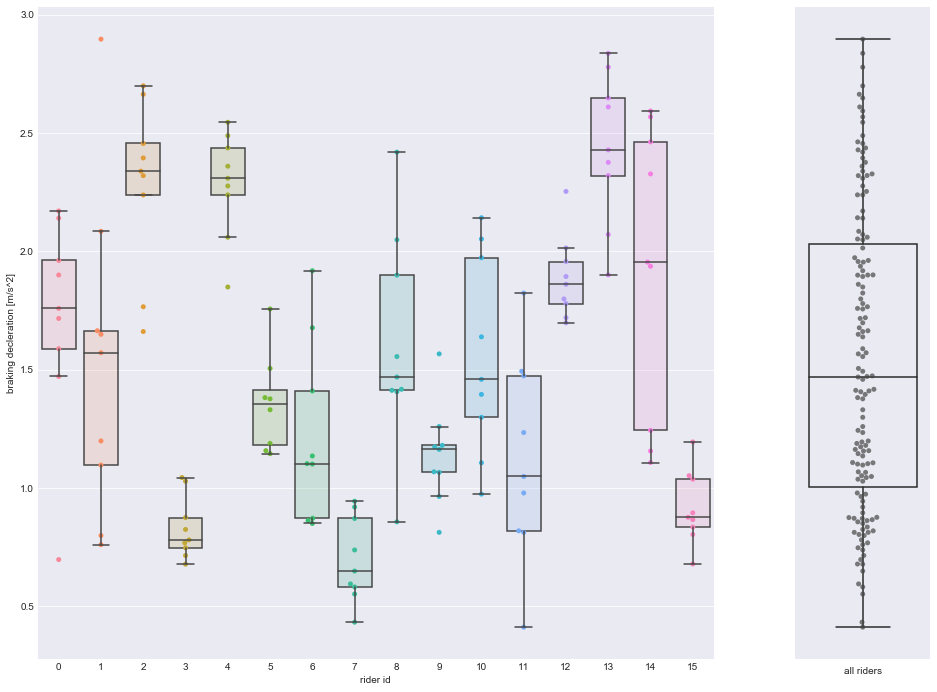

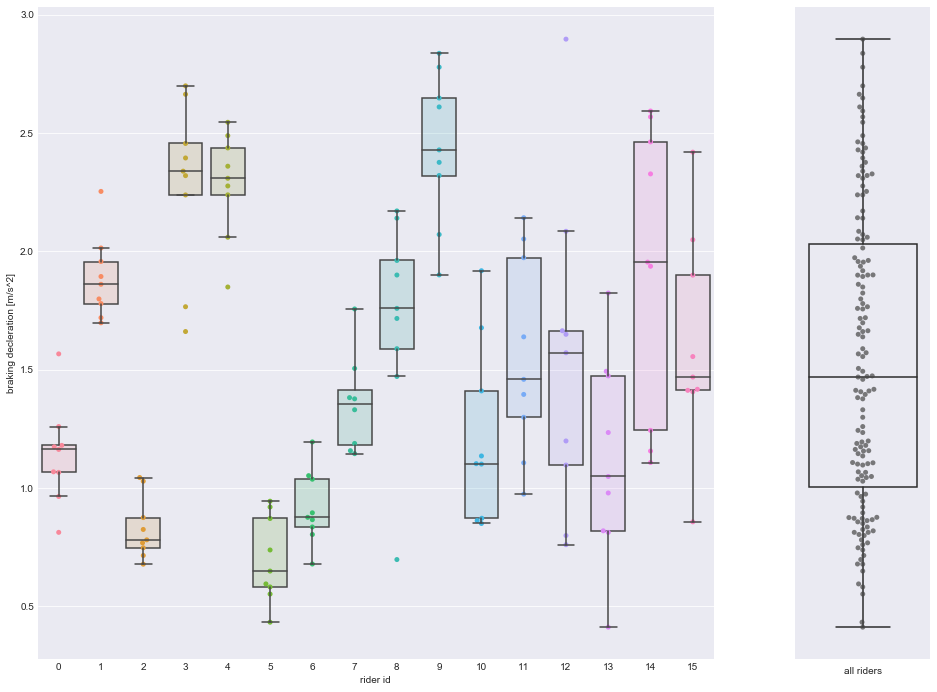

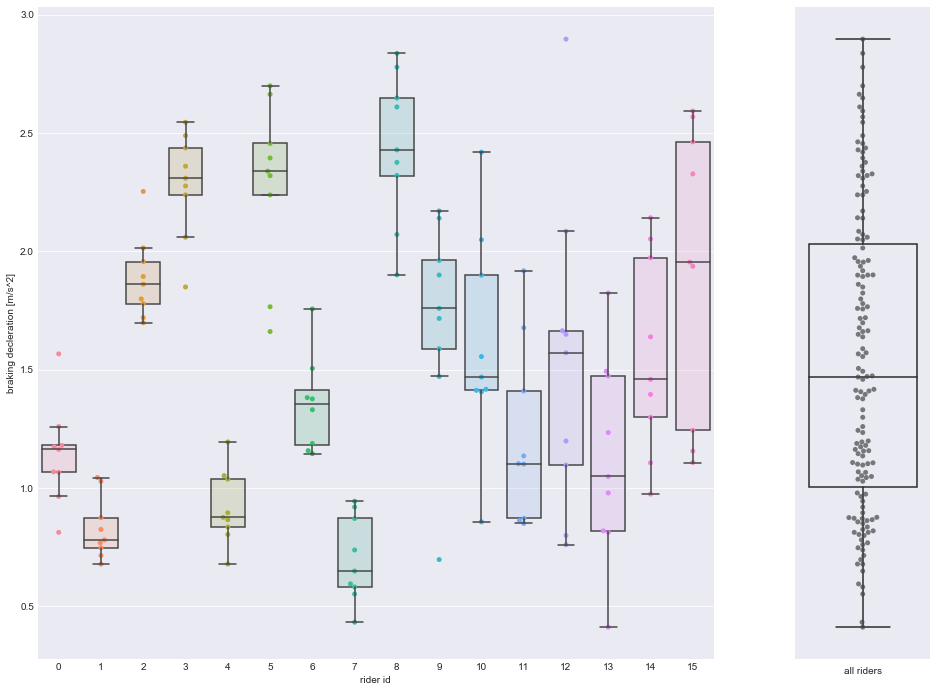

In [62]:
whisker_span = []
box_span = []

fig, ax = plt.subplots()
for i in range(num_riders):
    b = ax.boxplot(braking_df[braking_df['rider id'] == i]['deceleration'])
    [[box_min, whisker_min], [box_max, whisker_max]] = [item.get_ydata() for item in b['whiskers']]
    whisker_span.append(whisker_max - whisker_min)
    box_span.append(box_max - box_min)
plt.close('all')

whisker_order = np.argsort(np.argsort(whisker_span))
box_order = np.argsort(np.argsort(box_span))

braking_df2 = braking_df.copy(deep=True)
f = lambda row: sort_order[int(row['rider id'])]
braking_df2['whisker order'] = braking_df2.apply(f, axis=1)
f = lambda row: box_order[int(row['rider id'])]
braking_df2['box order'] = braking_df2.apply(f, axis=1)

fig, ax = plt.subplots(1, 2, sharey=True,
                       gridspec_kw={'width_ratios': [5, 1]})
sns.boxplot(x='deceleration', data=braking_df,
            color=helper.gray, ax=ax[1], 
            orient='v',
            showfliers=False,
            boxprops={'facecolor': (0, 0, 0, 0)})
sns.swarmplot(y='deceleration', data=braking_df,
              color=helper.gray, ax=ax[1],
              alpha=0.7)
    
boxswarmplot(x='rider id', y='deceleration',
             data=braking_df,
             ax=ax[0])

ax[0].set_ylabel('braking decleration [m/s^2]')
ax[1].get_yaxis().set_visible(False)
ax[0].set_xlabel('rider id')
ax[1].set_xlabel('all riders')

fig2, ax2 = plt.subplots(1, 2, sharey=True,
                         gridspec_kw={'width_ratios': [5, 1]})
sns.boxplot(x='deceleration', data=braking_df2,
            color=helper.gray, ax=ax2[1], 
            orient='v',
            showfliers=False,
            boxprops={'facecolor': (0, 0, 0, 0)})
sns.swarmplot(y='deceleration', data=braking_df2,
              color=helper.gray, ax=ax2[1],
              alpha=0.7)
    
boxswarmplot(x='whisker order', y='deceleration',
             data=braking_df2,
             ax=ax2[0])

ax2[0].set_ylabel('braking decleration [m/s^2]')
ax2[1].get_yaxis().set_visible(False)
ax2[0].set_xlabel('rider id')
ax2[1].set_xlabel('all riders')

fig3, ax3 = plt.subplots(1, 2, sharey=True,
                         gridspec_kw={'width_ratios': [5, 1]})
sns.boxplot(x='deceleration', data=braking_df2,
            color=helper.gray, ax=ax3[1], 
            orient='v',
            showfliers=False,
            boxprops={'facecolor': (0, 0, 0, 0)})
sns.swarmplot(y='deceleration', data=braking_df2,
              color=helper.gray, ax=ax3[1],
              alpha=0.7)
    
boxswarmplot(x='box order', y='deceleration',
             data=braking_df2,
             ax=ax3[0])

ax3[0].set_ylabel('braking decleration [m/s^2]')
ax3[1].get_yaxis().set_visible(False)
ax3[0].set_xlabel('rider id')
ax3[1].set_xlabel('all riders')

In [11]:
from antlia import filter as ff
from antlia import trial2

# 1.3 - linear model for velocity profile when braking
#
# Calculate normalized root mean square deviation for the
# braking event in each trial.
# https://en.wikipedia.org/wiki/Root-mean-square_deviation

def get_observed_predicted_velocity(trial_event, dataframe_entry):
    """Get observed and predicted velocity samples, excluding samples occurring 
    during wheel lockup.
    """
    # The necessary indices for calculating nrmsd were not saved. As a result,
    # we need to duplicate code to recreate them.
    i0 = np.searchsorted(trial_event.bicycle.time,
                         dataframe_entry['braking starttime'].values[0])
    # endtime is included
    i1 = np.searchsorted(trial_event.bicycle.time,
                         dataframe_entry['braking endtime'].values[0]) + 1
 
    v = np.squeeze(trial_event.kalman_smoothed_result.state_estimate[:, 3])
    if dataframe_entry['lockup ranges'].values[0] > 0:
        WINDOW_SIZE = 55
        a = ff.moving_average(trial_event.data['accelerometer x'],
                              WINDOW_SIZE, WINDOW_SIZE/2)
        
        lockup_indices = ((v < 0.2) & (a > 2.5))
        index = np.zeros(lockup_indices.shape, dtype=bool)
        index[i0:i1] = True
        index &= ~lockup_indices
    else:
        lockup_indices = slice(None)
        index = slice(i0, i1)
        
    observed = v[index]
    predicted = (dataframe_entry['linregress slope'].values[0]*trial_event.bicycle.time +
                 dataframe_entry['linregress intercept'].values[0])[index]
    return observed, predicted
   
    
def nrmsd(observed, predicted):
    rmsd = np.sqrt(np.sum((predicted - observed)**2)/len(observed))
    return rmsd/observed.mean()

nrmsd_values = []
for i in range(num_riders):
    if i == 15:
        # We skip rider 15 as data has been ignored
        # and renamed rider 16 to 15
        record_number = i + 1
    else:
        record_number = i
    record_filename = 'exp2record{:02d}.p.gz'.format(record_number)
    
    with gzip.open(record_filename, 'rb') as f:
        r = pickle.load(f)
        
    for j in range(len(r.trials)):
        evt = r.trials[j].event
        if evt.type != trial2.EventType.Braking:
            # skip overtaking trials
            continue

        df = braking_df[(braking_df['rider id'] == i) &
                        (braking_df['trial id'] == j)]
        nrmsd_values.append(nrmsd(*get_observed_predicted_velocity(evt, df)))
        
# Add nrmsd column
braking_df['linregress nrmsd'] = nrmsd_values

In [13]:
print('nrmsd median: ', braking_df['linregress nrmsd'].mean())
print('nrmsd std: ', braking_df['linregress nrmsd'].std())

nrmsd median:  0.0734547151477
nrmsd std:  0.0354643636141


Text(0.5,0,'all riders')

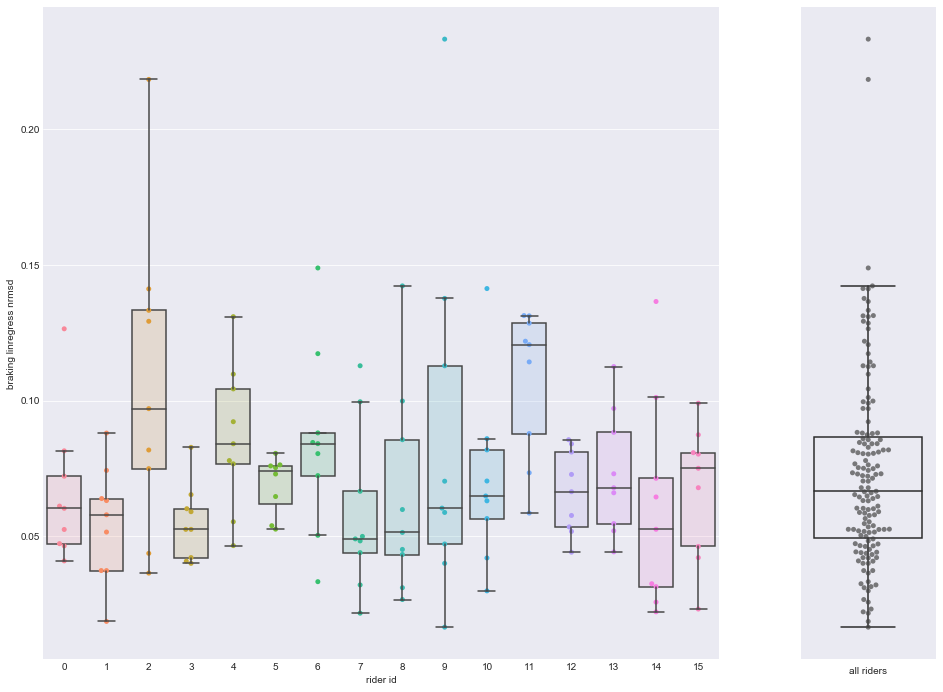

In [427]:
fig, ax = plt.subplots(1, 2, sharey=True,
                       gridspec_kw={'width_ratios': [5, 1]})
                       
plot_swarm_overlay = True
                       
if not plot_swarm_overlay:
    # get a ligher gray for the box face color
    c = sns.light_palette(helper.gray)[3]
    sns.boxplot(x='linregress nrmsd', data=braking_df,
                color=helper.gray, ax=ax[1], 
                orient='v',
                boxprops={'facecolor': c})
else:
    sns.boxplot(x='linregress nrmsd', data=braking_df,
                color=helper.gray, ax=ax[1], 
                orient='v',
                showfliers=False,
                boxprops={'facecolor': (0, 0, 0, 0)})
    sns.swarmplot(y='linregress nrmsd', data=braking_df,
                  color=helper.gray, ax=ax[1],
                  alpha=0.7)
    #sns.distplot(braking_df['linregress nrmsd'].values,
    #             color=helper.gray, ax=ax[1],
    #             fit=scipy.stats.norm,
    #             vertical=True)
    #ax[1].autoscale(axis='x')

if not plot_swarm_overlay:
    sns.boxplot(x='rider id', y='linregress nrmsd',
                data=braking_df,
                ax=ax[0])
else:
    boxswarmplot(x='rider id', y='linregress nrmsd',
                 data=braking_df,
                 ax=ax[0])
ax[0].set_ylabel('braking linregress nrmsd')
ax[1].get_yaxis().set_visible(False)
ax[0].set_xlabel('rider id')
ax[1].set_xlabel('all riders')

In [6]:
import scipy.spatial
import matplotlib.patches
import matplotlib.collections

def plot_eventtype_comparison(df_a, df_b, key, colors=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    if colors is None:
        colors = sns.color_palette('tab10', 10)
        
    ax.scatter(*df_a[['starting velocity', key]].values.T,
               color=colors[0], 
               label='braking')
    ax.scatter(*df_b[['starting velocity', key]].values.T,
               color=colors[1], 
               label='steering')
    patches = []
    for i, df in enumerate([df_a, df_b]):
        X = df[['starting velocity', key]].as_matrix()
        hull = scipy.spatial.ConvexHull(X)
        polygon = matplotlib.patches.Polygon(X[hull.vertices, :],
                                             closed=True,
                                             color=colors[i],
                                             zorder=1)
        patches.append(polygon)

    p = matplotlib.collections.PatchCollection(patches,
                                               match_original=True,
                                               alpha=0.05)
    ax.add_collection(p)
    ax.legend()
    return ax

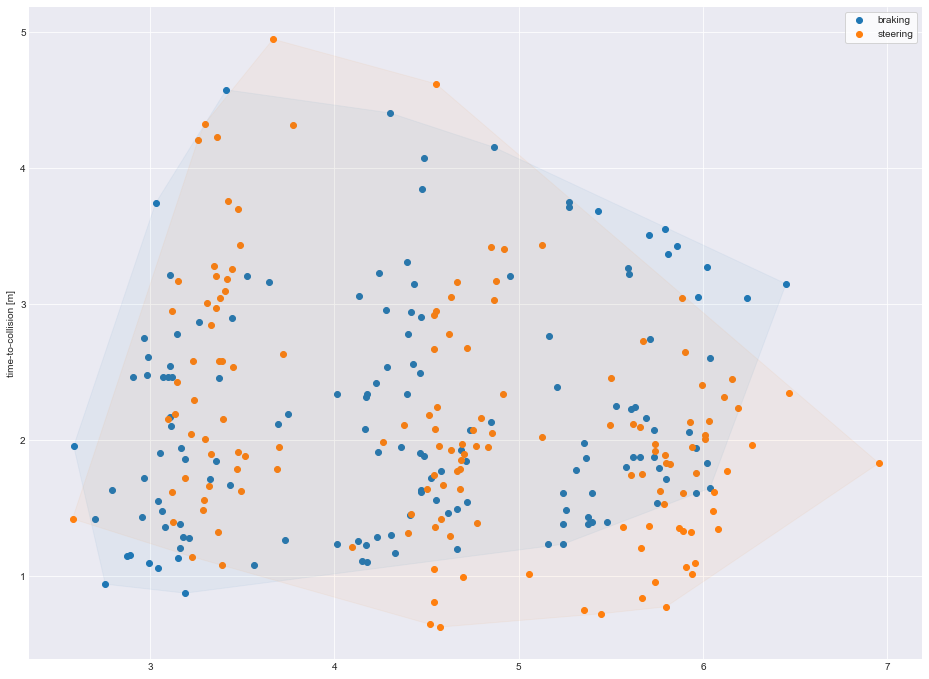

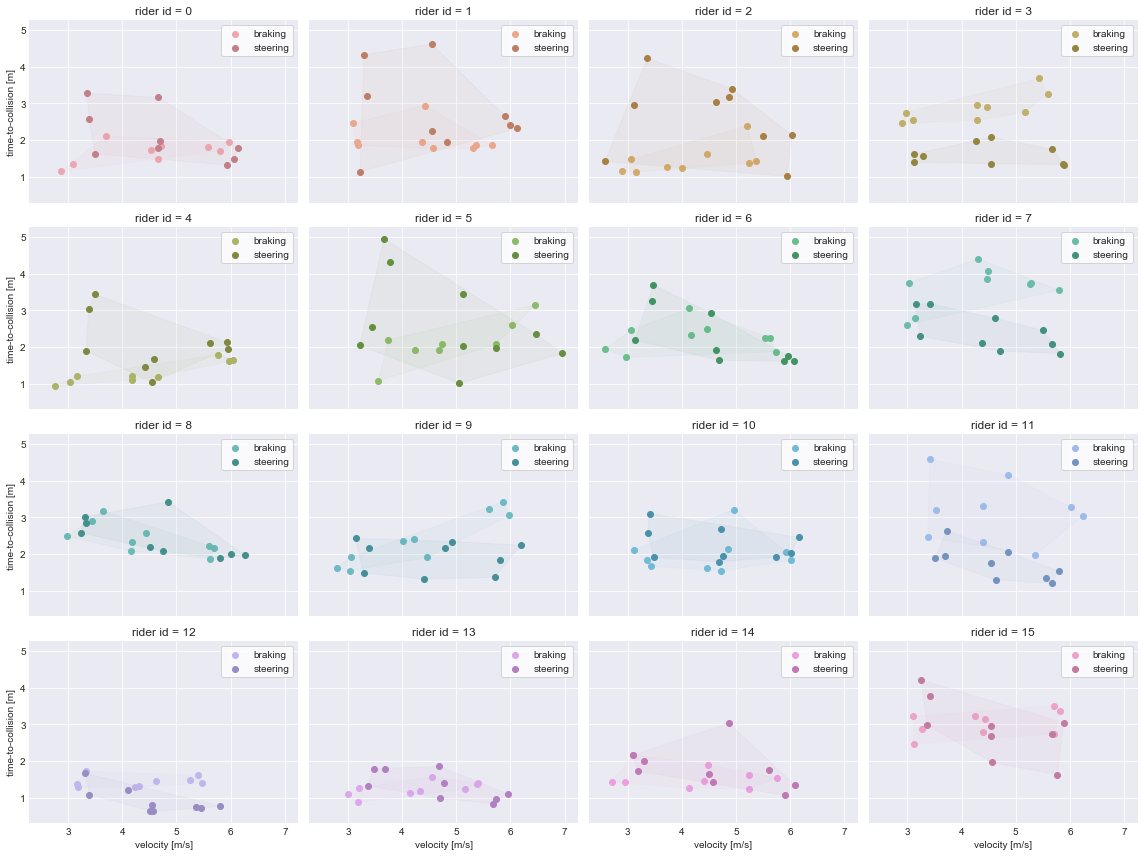

In [8]:
CATEGORICAL_PLOT_SATURATION = 0.75
helper = sns.categorical._CategoricalPlotter()
helper.hue_names = list(range(16))
helper.establish_colors(color=None, palette=None,
                        saturation=CATEGORICAL_PLOT_SATURATION)

key = 'time-to-collision'
key_unit = 'm'

plt.close('all')
ax = plot_eventtype_comparison(braking_df, steering_df, key)
ax.set_ylabel('{} [{}]'.format(key, key_unit))

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    c0 = sns.light_palette(helper.colors[i])[4]
    c1 = sns.dark_palette(helper.colors[i])[4]
    
    df_a = braking_df[braking_df['rider id'] == i]
    df_b = steering_df[steering_df['rider id'] == i]
    plot_eventtype_comparison(df_a, df_b, key,
                              colors=[c0, c1], ax=ax)
    ax.set_title('rider id = {}'.format(i))
    
for ax in axes[-1, :]:
    ax.set_xlabel('velocity [m/s]')
for ax in axes[:, 0]:
    ax.set_ylabel('{} [{}]'.format(key, key_unit))
fig.tight_layout()
plt.show()